<a href="https://colab.research.google.com/github/Yuvaraj0001/EVA7_Assignments/blob/main/Session%206/Normalization/Layer_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device & Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model

In [6]:
dropout_value = 0.05


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2,2), ## Squeeze
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), ## Pointwise Convolution
        ) # output_size = 12
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=24),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) ## Global Average Pooling
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), ## Increase (expand) number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), ## Reduce down number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=1, num_channels=16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), ## Reduce number of channels to output required
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test Model

In [9]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

lambda1 = lambda epoch: 0.65 ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lambda1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.2269444614648819 Batch_id=468 Accuracy=69.29: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.1202, Accuracy: 9701/10000 (97.01%)

EPOCH: 2


Loss=0.26355233788490295 Batch_id=468 Accuracy=92.85: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.0696, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


Loss=0.11472824960947037 Batch_id=468 Accuracy=95.13: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]



Test set: Average loss: 0.0599, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Loss=0.07457073777914047 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s]



Test set: Average loss: 0.0408, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.08087166398763657 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0442, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.05700045824050903 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:47<00:00,  9.93it/s]



Test set: Average loss: 0.0373, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.04276074469089508 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:47<00:00,  9.91it/s]



Test set: Average loss: 0.0343, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.0394093319773674 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:46<00:00,  9.99it/s]



Test set: Average loss: 0.0408, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.19502978026866913 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]



Test set: Average loss: 0.0382, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.15128199756145477 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:47<00:00,  9.88it/s]



Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.15057291090488434 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:47<00:00,  9.88it/s]



Test set: Average loss: 0.0256, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.12590213119983673 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:47<00:00,  9.92it/s]



Test set: Average loss: 0.0307, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.15088984370231628 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.11517069488763809 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.0241, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.060046594589948654 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:47<00:00,  9.95it/s]



Test set: Average loss: 0.0267, Accuracy: 9913/10000 (99.13%)

EPOCH: 16


Loss=0.018380068242549896 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s]



Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.07251443713903427 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s]



Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.11034902185201645 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 19


Loss=0.035353709012269974 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]



Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.025594601407647133 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)



## Training & Testing Loss Curves

Text(0.5, 1.0, 'Test Accuracy')

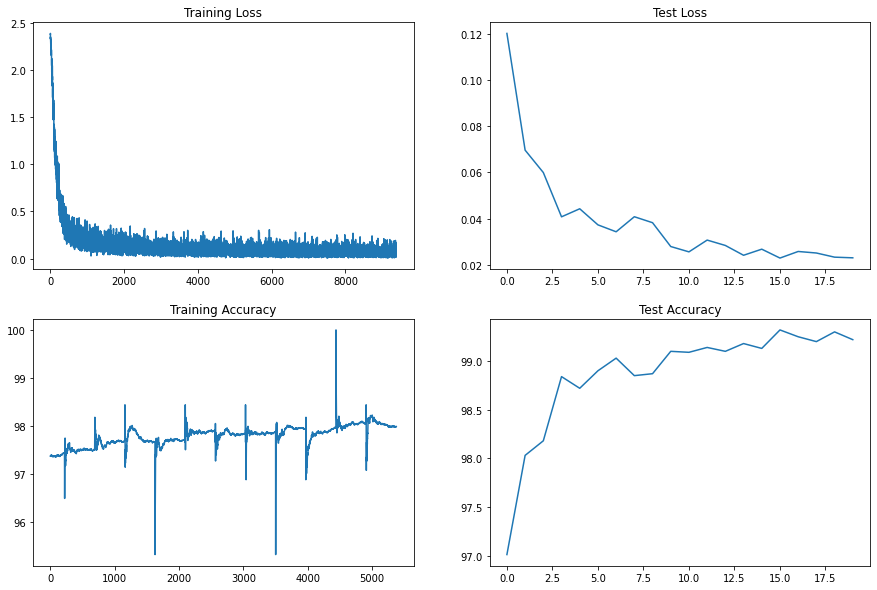

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Misclassification images

In [11]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
   
    return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [12]:
wrong_predictions = wrong_predictions(test_loader,model,device)
print(f'Total wrong predictions are {len(wrong_predictions)}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 78


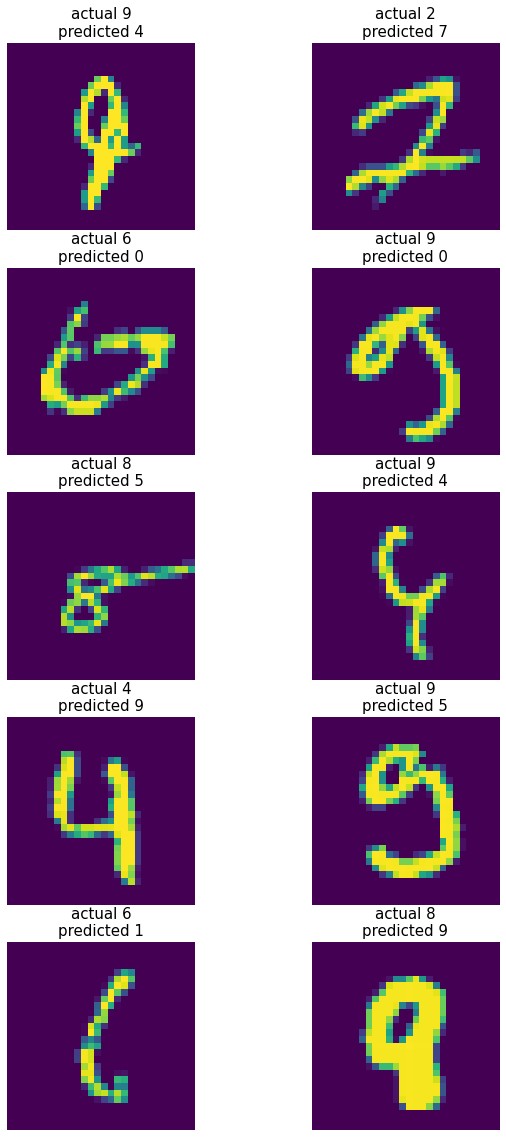

In [13]:
fig = plt.figure(figsize=(10,20))
for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(5, 2, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()